In [1]:
import jax
import jax.numpy as np
import flax.linen as nn
import optax
import diffrax as dfx
import matplotlib.pyplot as plt
import numpy as onp

from typing import Sequence, Callable
import tensorflow_probability.substrates.jax as tfp
from tqdm import trange

tfd = tfp.distributions

/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.9/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


## Standalone diffeq solver

In [211]:
def phi_plummer(pos, a=1., G=1., M=1.):
    """ Plummer potential; `pos` is a vector of shape (3,), a is the scale radius
    """
    r = np.sqrt(np.sum(pos**2))
    return -G * M / (np.sqrt(r ** 2 + a**2))

def dxdt(t, xv, args):
    x, v = xv
    return (v, np.zeros_like(v))  # dx/dt = v

def dvdt(t, xv, args):
    x, v = xv
    potential = phi_plummer
    grad_potential = jax.grad(potential)
    print(grad_potential(x))
    return (np.zeros_like(x), -grad_potential(x))  # dv/dt = a =-grad(potential)    

# Solve differential equation
terms = dfx.MultiTerm(dfx.ODETerm(dxdt), dfx.ODETerm(dvdt))
            
stepsize_controller = dfx.ConstantStepSize()
solver = dfx.LeapfrogMidpoint()
saveat = dfx.SaveAt(ts=np.linspace(0.0, 10.0, 100))
y0 = (np.array([1., 0., 0.]), np.array([0., 0.5, 0.]))
dt = 0.1
sol = dfx.diffeqsolve(terms, solver, 0.0, 10.0, dt, y0=y0, args=(), saveat=saveat, stepsize_controller=stepsize_controller)

Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=2/0)>


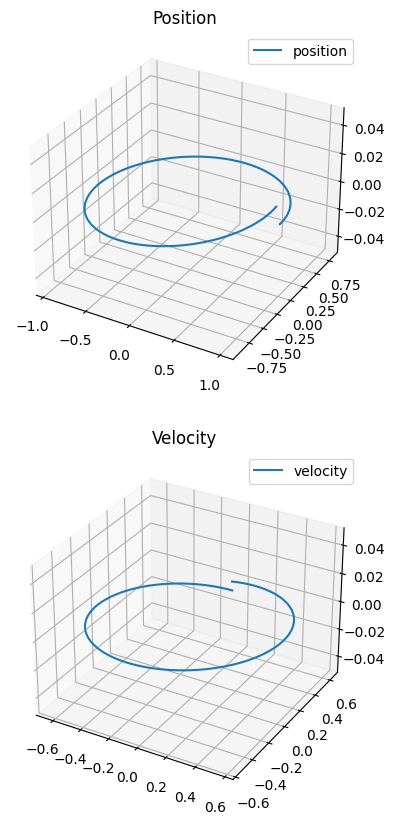

In [214]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))

# Create a 3D plot for position
ax1 = fig.add_subplot(211, projection='3d')
ax1.plot(sol.ys[0][:, 0], sol.ys[0][:, 1], sol.ys[0][:, 2], label='position')
ax1.set_title("Position")
ax1.legend()

# Create a 3D plot for velocity
ax2 = fig.add_subplot(212, projection='3d')
ax2.plot(sol.ys[1][:, 0], sol.ys[1][:, 1], sol.ys[1][:, 2], label='velocity')
ax2.set_title("Velocity")
ax2.legend()

plt.show()


## The dataset

In [5]:
def phi_plummer(pos, a=1., G=1., M=1.):
    """ Plummer potential; `pos` is a vector of shape (3,), a is the scale radius
    """
    x, y, z = pos
    return -G * M / (np.sqrt(x**2 + y**2 + z**2 + a**2))

def phi_nfw(pos, a=1., G=1., M=1.):
    """ NFW potential; `pos` is a/ vector of shape (3,), a is the scale radius
    """
    r = np.linalg.norm(pos)
    return -G * M * np.log(1 + r / a) / r

# Plummer Distribution Function
def f_plummer(xv, a=1., G=1., M=1.):
    """ Plummer distribution function; `xv` is a vector of shape (6,), `a` is the scale radius
    """
    x, y, z, vx, vy, vz = xv
    phi = -phi_plummer(np.array([x, y, z]), a=a, G=G, M=M)
    q = (1/2) * (vx**2 + vy**2 + vz**2)
    return np.where(phi > q, (24 * np.sqrt(2) * np.pi**3 * a**6 * G**3 * M**3)**(-1) * (phi - q)**(7/2), 0)

In [6]:
import emcee

# Use emcee to sample from the distribution function
sampler = emcee.EnsembleSampler(nwalkers=32, ndim=6, log_prob_fn=lambda xv: np.log(f_plummer(xv, a=1.)))
sampler.run_mcmc(onp.random.randn(32, 6) * 5e-5, 2500, progress=True);

100%|██████████| 2500/2500 [00:28<00:00, 87.20it/s]


In [149]:
n_samples = 100000

# Get flattened chain; reject burn-in
xv_samples = sampler.get_chain(discard=500, flat=True)
xv_samples = xv_samples[-n_samples:]

# For base distribution, use mean and std of samples
xv_mean = np.mean(xv_samples, axis=0)
xv_std = np.std(xv_samples, axis=0)

pos, vel = xv_samples[:, :3], xv_samples[:, 3:]

print(pos.shape, vel.shape)

(64000, 3) (64000, 3)


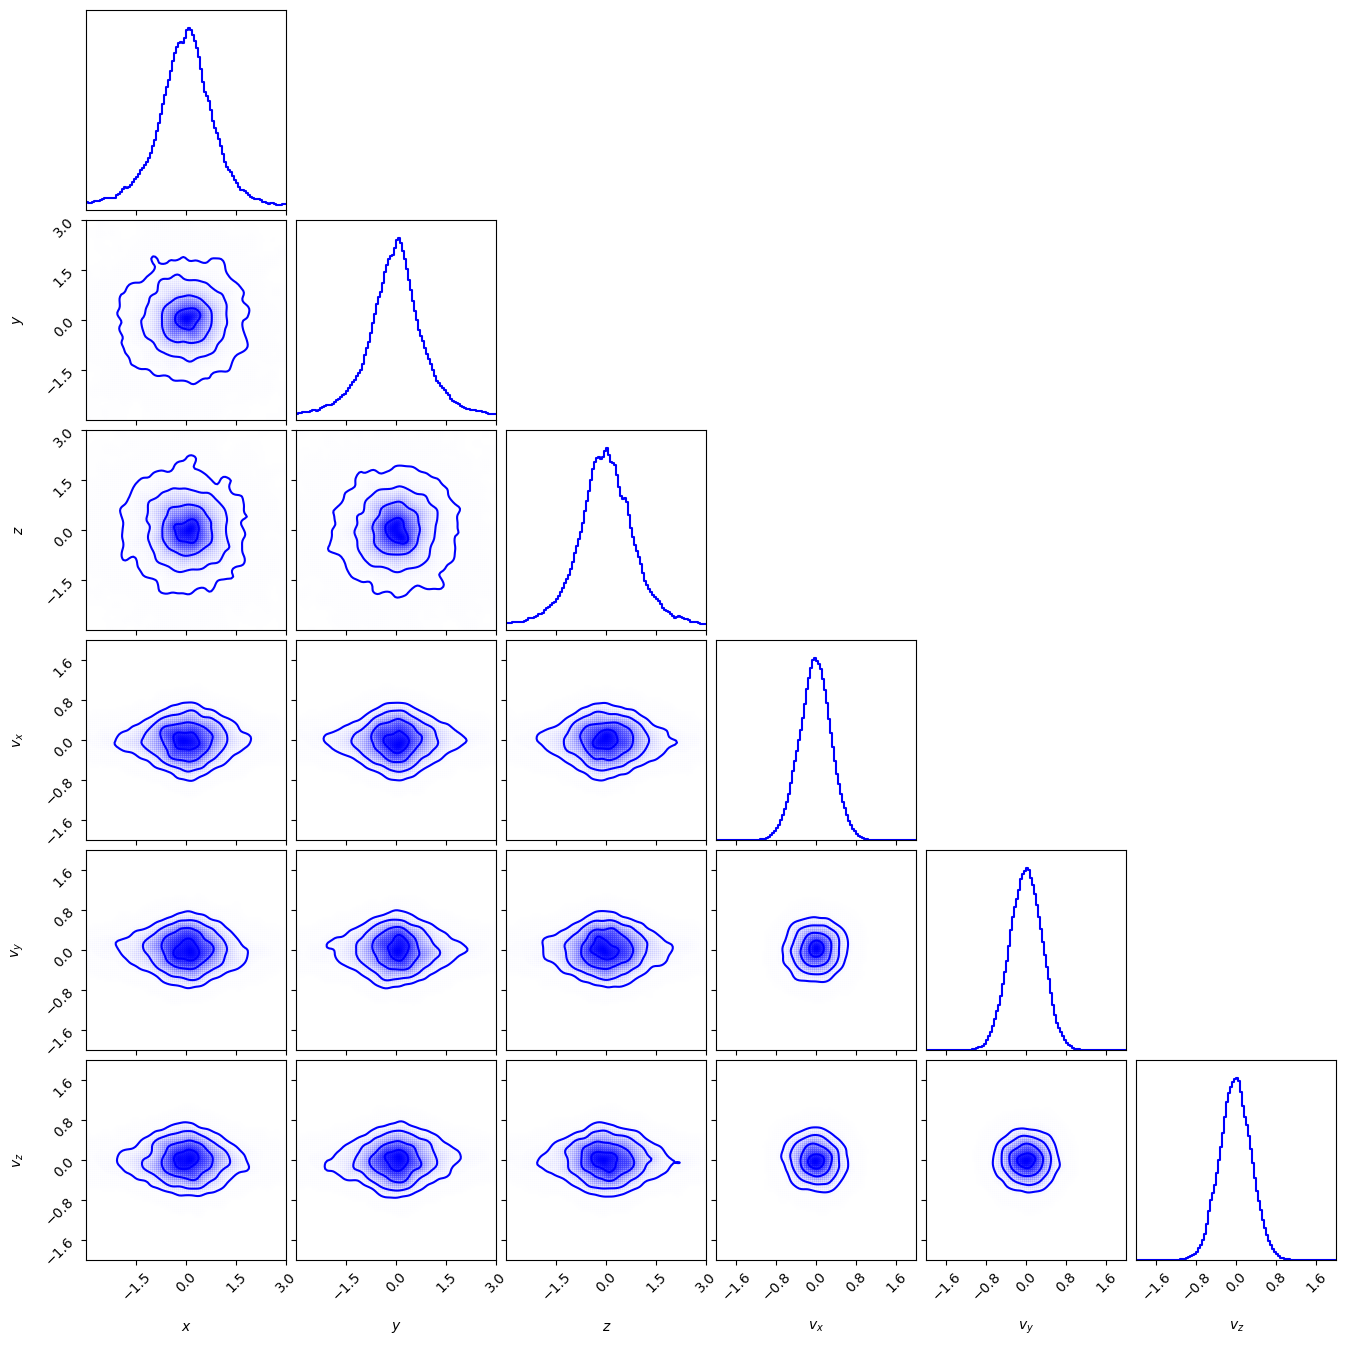

In [150]:
import corner

plot_args = {"range": [(-3, 3), (-3, 3), (-3, 3), (-2, 2), (-2, 2), (-2, 2)], "bins": 100, "smooth": 2., "smooth1d": 1., "plot_datapoints": False, "plot_density": True}

# Plot two datasets on the same corner plot
corner.corner(onp.array(xv_samples), labels=[r"$x$", r"$y$", r"$z$", r"$v_x$", r"$v_y$", r"$v_z$"], color="blue", alpha=0.5, **plot_args);

## The flow

In [178]:
def get_timestep_embedding(timesteps, embedding_dim: int, dtype=np.float32):
    """Build sinusoidal embeddings (from Fairseq)."""

    assert len(timesteps.shape) == 1
    timesteps *= 1000

    half_dim = embedding_dim // 2
    emb = np.log(10_000) / (half_dim - 1)
    emb = np.exp(np.arange(half_dim, dtype=dtype) * -emb)
    emb = timesteps.astype(dtype)[:, None] * emb[None, :]
    emb = np.concatenate([np.sin(emb), np.cos(emb)], axis=1)
    if embedding_dim % 2 == 1:  # Zero pad
        emb = jax.lax.pad(emb, dtype(0), ((0, 0, 0), (0, 1, 0)))
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb

class MLP(nn.Module):
    """A simple MLP (fully-connected neural network)."""

    feature_sizes: Sequence[int]
    activation: Callable[[np.ndarray], np.ndarray] = nn.gelu
    d_t_emd: int = 16
    spherically_symmetric: bool = False

    @nn.compact
    def __call__(self, x, t):
        
        # Timestep embedding
        t = get_timestep_embedding(t, self.d_t_emd)
        t = np.squeeze(t)

        if self.spherically_symmetric:
            # Get just the norm of x; spherically symmetric potential
            x = np.linalg.norm(x, axis=-1, keepdims=True)

        x = np.concatenate([x, t], axis=-1)
        for features in self.feature_sizes[:-1]:
            x = nn.Dense(features)(x)
            x = self.activation(x)
            x = np.concatenate([x, t], axis=-1)
        x = nn.Dense(self.feature_sizes[-1])(x)
        return x


class SymplecticFlow(nn.Module):
    T: float = 1.0  # Total time
    dt: float = 0.05  # Time step
    solver: dfx.AbstractSolver = dfx.LeapfrogMidpoint()  # Diffrax solver
    n_transforms: int = 4  # Number of flow transforms
    d_hidden: int = 64  # Hidden dims of MLP
    n_layers: int = 4  # Hidden layers in MLP
    n_dim: int = 2  # Parameter dim

    def setup(self):
        self.potential_funcs = [MLP([self.d_hidden] * self.n_layers + [1]) for _ in range(self.n_transforms)]
        self.stepsize_controller = dfx.ConstantStepSize() if type(self.solver) is dfx.LeapfrogMidpoint else dfx.PIDController(atol=1e-4, rtol=1e-4)    

    def dxdt(self, t, xv, args):
        params, i = args
        x, v = xv
        return (v, np.zeros_like(v))  # dx/dt = v
    
    def dvdt(self, t, xv, args):
        params, i = args
        x, v = xv
        potential = lambda x: self.potential_funcs[i].apply({'params': params}, x, np.atleast_1d(t))[0]
        grad_potential = jax.grad(potential)
        return (np.zeros_like(x), -grad_potential(x))  # dv/dt = a =-grad(potential)    
    
    def log_prob(self, xv):
        """ Log-probability of flow for a single sample `xv`."""

        if self.is_initializing():
            x, v = np.split(xv, 2, axis=-1)
            for i in range(self.n_transforms):
                self.potential_funcs[i](x, np.atleast_1d(0.0))

        ode_params = [potential_func.variables['params'] for potential_func in self.potential_funcs]

        # Base distribution is just a standard normal
        base_dist = tfd.MultivariateNormalDiag(loc=np.zeros_like(xv), scale_diag=np.ones_like(xv))

        pos, vel = np.split(xv, 2, axis=-1)

        for i in range(self.n_transforms):

            y0 = (pos, vel)
            terms = dfx.MultiTerm(dfx.ODETerm(self.dxdt), dfx.ODETerm(self.dvdt))
            
            sol = dfx.diffeqsolve(terms, self.solver, self.T, 0.0, -self.dt, y0=y0, args=(ode_params[i], i), stepsize_controller=self.stepsize_controller)
            
            pos, vel = sol.ys
            pos, vel = pos[0], vel[0]            

        xv = np.concatenate([pos, vel], axis=-1)

        # Compute log-density
        log_prob = base_dist.log_prob(xv)

        return log_prob

    def sample_single(self, key):
        """ Single sample from the flow."""

        key, subkey = jax.random.split(key)
        xv = jax.random.normal(subkey, shape=(self.n_dim,))

        pos, vel = np.split(xv, 2, axis=-1)

        ode_params = [potential_func.variables['params'] for potential_func in self.potential_funcs]

        # Forward flow
        for i in range(self.n_transforms - 1, -1, -1):

            y0 = (pos, vel)
            terms = dfx.MultiTerm(dfx.ODETerm(self.dxdt), dfx.ODETerm(self.dvdt))

            sol = dfx.diffeqsolve(terms, self.solver, 0.0, self.T, self.dt, y0=y0, args=(ode_params[i], i), stepsize_controller=self.stepsize_controller)
            pos, vel = sol.ys
            pos, vel = pos[0], vel[0]

        return np.concatenate([pos, vel], axis=-1)

    def sample(self, key, n_samples):
        """ Batch of samples from the flow."""
        sample_key = jax.random.split(key, n_samples)
        return jax.vmap(self.sample_single)(sample_key)
    
    def __call__(self, x):
        """Batched log-prob."""
        return jax.vmap(self.log_prob)(x)

In [179]:
n_dim = 6

flow = SymplecticFlow(n_dim=n_dim, solver=dfx.LeapfrogMidpoint())
xv = jax.random.normal(jax.random.PRNGKey(0), (100, n_dim))

rng = jax.random.PRNGKey(0)
log_prob, params = flow.init_with_output(rng, xv)

In [180]:
# Sample
flow.apply(params, rng, 100, method=flow.sample);

## Train

In [181]:
# opt = optax.sgd(learning_rate=1e-4, momentum=0.99, nesterov=True)
opt = optax.adam(learning_rate=1e-4)
opt_state = opt.init(params)

In [182]:
@jax.jit
def loss_fn(params, x):
    log_prob = flow.apply(params, x)
    return -log_prob.mean()

In [187]:
n_steps = 2000
n_batch = 128

key = jax.random.PRNGKey(42)

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, xv_samples.shape[0], shape=(n_batch,))
        
        x_batch = xv_samples[idx]
        
        loss, grads = jax.value_and_grad(loss_fn)(params, x_batch)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

## Sample

In [184]:
xv_samples_phase = flow.apply(params, rng, 100000, method=flow.sample)

In [185]:
xv_samples_phase.shape

(100000, 6)

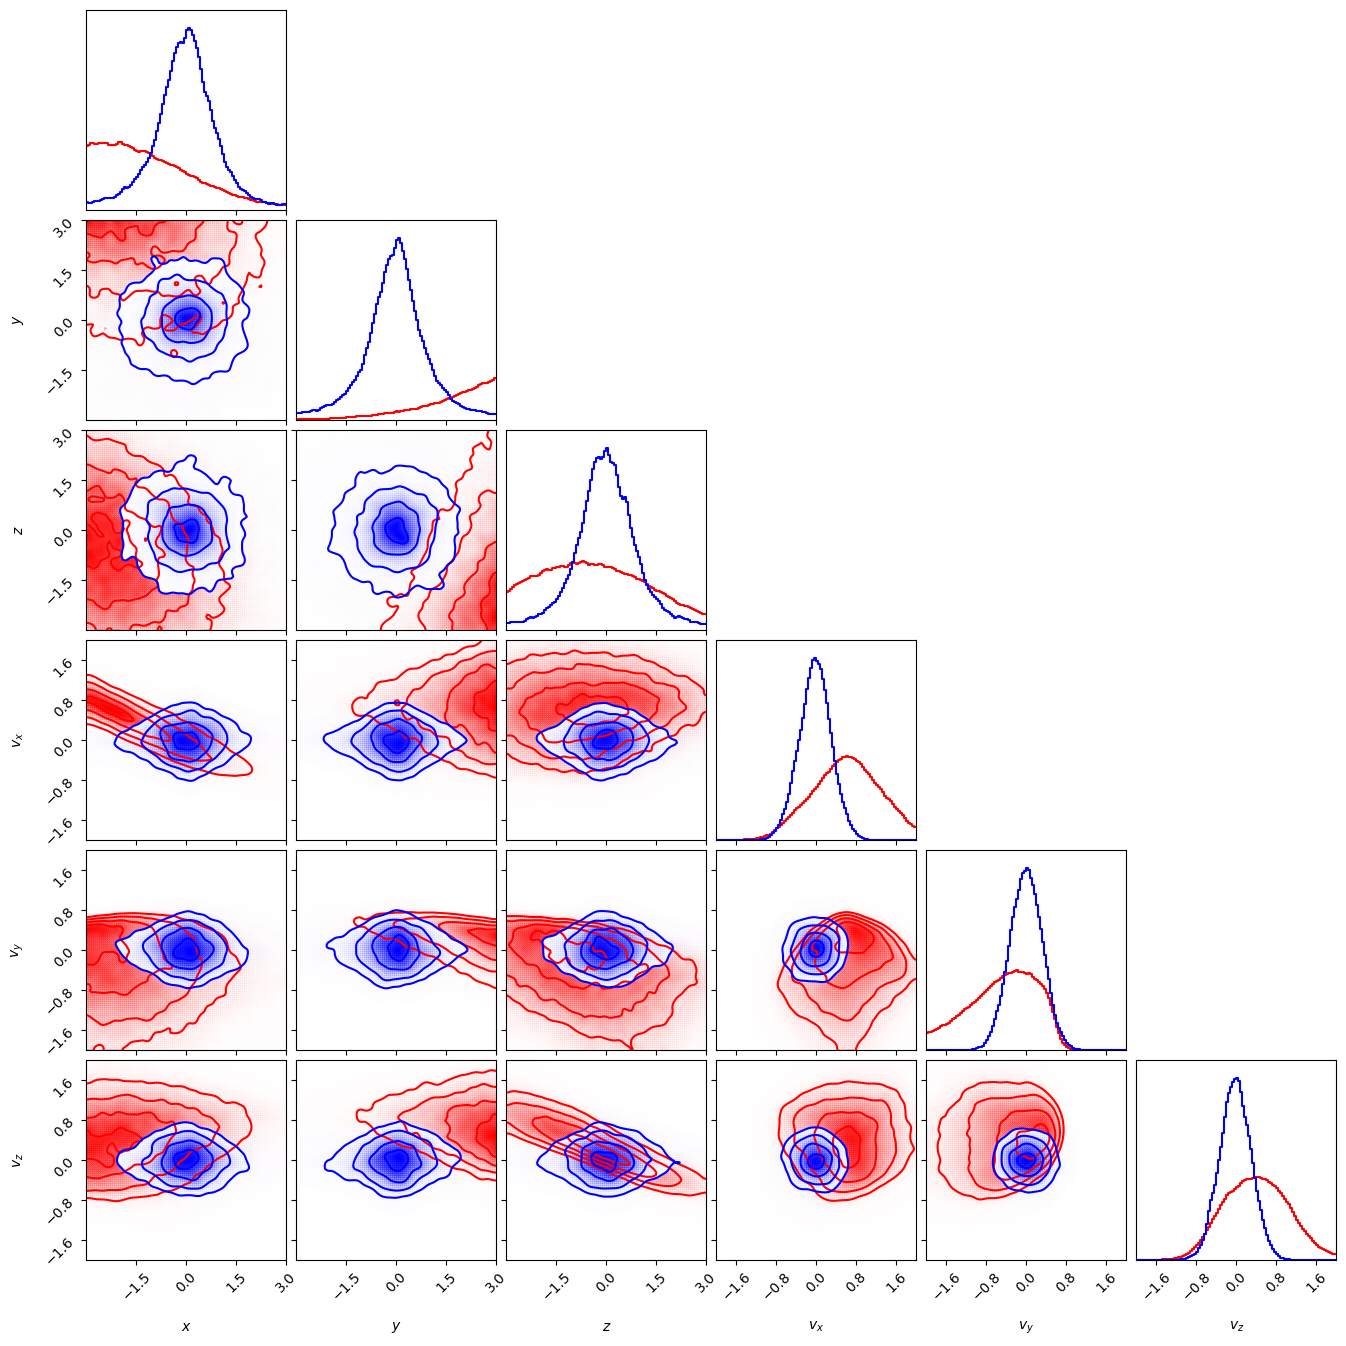

In [186]:
plot_args = {"range": [(-3, 3), (-3, 3), (-3, 3), (-2, 2), (-2, 2), (-2, 2)], "bins": 100, "smooth": 2., "smooth1d": 1., "plot_datapoints": False, "plot_density": True}

# Plot two datasets on the same corner plot
fig = corner.corner(onp.array(xv_samples_phase), labels=[r"$x$", r"$y$", r"$z$", r"$v_x$", r"$v_y$", r"$v_z$"], color="red", alpha=0.5, **plot_args);
corner.corner(onp.array(xv_samples), labels=[r"$x$", r"$y$", r"$z$", r"$v_x$", r"$v_y$", r"$v_z$"], color="blue", alpha=0.5, fig=fig, weights=np.ones(xv_samples.shape[0]) * xv_samples_phase.shape[0] / xv_samples.shape[0], **plot_args);